In [13]:
import os
os.getcwd()
os.chdir("C:/Users/HP/Desktop/dataset")
os.getcwd()  #changing working directory

'C:\\Users\\HP\\Desktop\\dataset'

In [14]:

# K-Means Clustering on AfSIS Soil Chemistry Data
# Part 1: Import and Prepare the Dataset

import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

#Defining path to CSV
# starting file: Wet chemistry (soil properties like pH, nutrients)
csv_path = '2009-2013/Wet_Chemistry/CROPNUTS/Wet_Chemistry_CROPNUTS.csv'

#Loading the dataset
try:
    df = pd.read_csv(csv_path)
    print(f"\nDataset loaded successfully! Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumns:")
    print(df.columns.tolist())
except FileNotFoundError:
    print(f"Error: File not found at {csv_path}")
    print("Tip: Wet_Chemistry/' to check paths")
    print("Or download with: Wet_Chemistry_CROPNUTS.csv .")
    raise  # Stop here if file missing

#Quick inspection & cleaning
print("\nData types and non-null counts:")
print(df.info())

# Identifying potential feature columns (numerical soil properties)
# For wet chemistry CSVs, I looked for columns like: pH, Organic_C, Total_N, Olsen_P, K, Ca, Mg, etc.
# As part of dimensionality reduction I removed the geographical features since I won't be needing them for clustering
possible_features = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nPotential numerical features for clustering: {len(possible_features)} columns")
print(possible_features)

# Selecting features & handling missing values

feature_cols = ['pH', 'Organic_C', 'Total_N', 'Olsen_P', 'K', 'Ca', 'Mg', 'Na']

# Filter to existing columns only
available_features = [col for col in feature_cols if col in df.columns]
if len(available_features) < 3:
    print("Warning: Few matching feature columns. Using all numeric instead.")
    available_features = possible_features[:10]  # limit to avoid too many dimensions

X = df[available_features].copy()

# Handling missing values: simple imputation (mean)
X = X.fillna(X.mean(numeric_only=True))
print(f"\nFeatures selected ({X.shape[1]} columns): {X.columns.tolist()}")
print(f"Rows after prep: {X.shape[0]} (dropped any fully-missing if needed)")

# Scale features (CRITICAL for K-Means – distance-based!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nData scaled. Ready for K-Means!")


Dataset loaded successfully! Shape: (1907, 19)

First 5 rows:
         SSN  Public     EC  ExAc      ExBas   M3 Al    M3 B   M3 Ca   M3 Cu  \
0  icr006475    True  0.053  2.56   2.744241  1095.0  0.3337   207.1  1.3150   
1  icr006586    True  0.193  0.59  16.797753  1165.0  0.7899  1665.0  2.8140   
2  icr007929    True  0.305  0.19  16.503619   727.6  0.6142  2518.0  0.2496   
3  icr008008    True  0.053  0.48   6.302775  1458.0  0.3603   734.3  1.3690   
4  icr010198    True  0.032  1.05   2.390303  2166.0  0.0100   261.8  1.6860   

    M3 Fe     M3 K  M3 Mg    M3 Mn  M3 Na     M3 P    M3 S  M3 Zn     PH  \
0  153.70   306.30   89.5    9.266  42.71    4.495  18.960  2.825  4.682   
1  126.80  1186.00  636.7  254.700  40.83   12.510  13.600  1.952  7.062   
2  260.40    72.57  428.5   35.820  42.94   21.090  14.810  2.742  7.114   
3  134.10   274.60  222.5   29.110  20.73  109.200  11.400  0.980  5.650   
4   97.49    91.76   76.5  375.200  49.31    3.958   5.281  1.258  5.501   



Using 16 features: ['EC', 'ExAc', 'ExBas', 'M3 Al', 'M3 B', 'M3 Ca', 'M3 Cu', 'M3 Fe', 'M3 K', 'M3 Mg', 'M3 Mn', 'M3 Na', 'M3 P', 'M3 S', 'M3 Zn', 'PH']
Rows for clustering: 1907
Features scaled successfully.


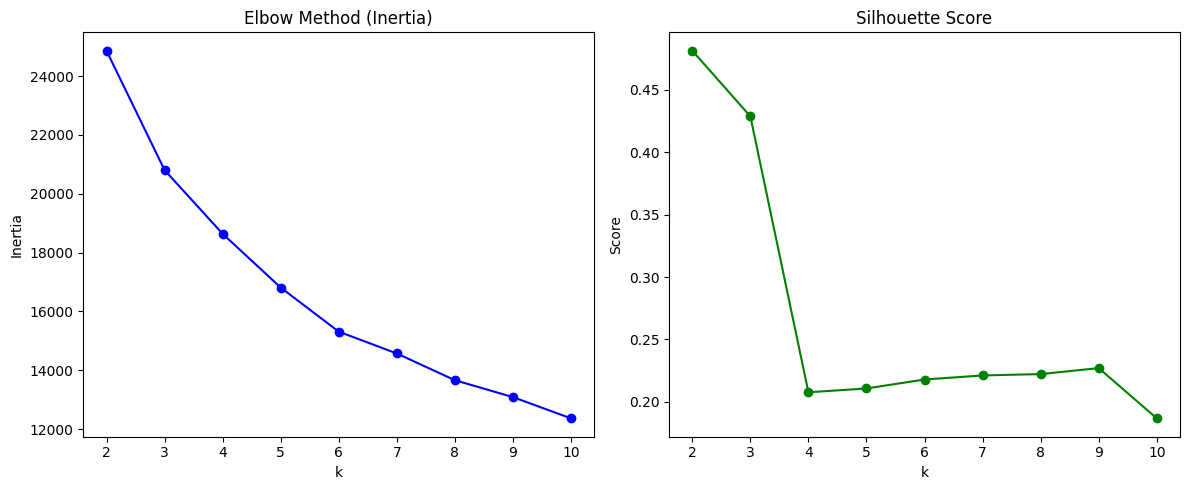


Fitting K-Means with k = 4

Cluster sizes:
Cluster
0    1223
1     229
2       8
3     447
Name: count, dtype: int64

Cluster Centroids (original units):
             EC  ExAc   ExBas    M3 Al   M3 B    M3 Ca  M3 Cu   M3 Fe  \
Cluster 0  0.07  0.27    7.65   685.49   0.20  1021.21   1.76  103.95   
Cluster 1  0.43  0.20   55.61   576.47   1.88  8955.45   2.94   72.94   
Cluster 2  3.84  0.44  107.83   674.98  15.90  3975.82   1.98  232.19   
Cluster 3  0.06  1.18    3.43  1316.45   0.08   406.71   1.21  151.92   

              M3 K    M3 Mg   M3 Mn     M3 Na   M3 P     M3 S  M3 Zn    PH  
Cluster 0   123.37   245.53  107.50     46.69  11.01     8.76   1.61  6.26  
Cluster 1   561.30   972.88  165.95    312.77  29.59    55.27   1.79  7.98  
Cluster 2  1339.35  2138.64   62.39  15374.72  13.61  2282.09   4.43  5.80  
Cluster 3    93.48   121.89   42.37     35.69   7.00    12.96   1.15  5.17  


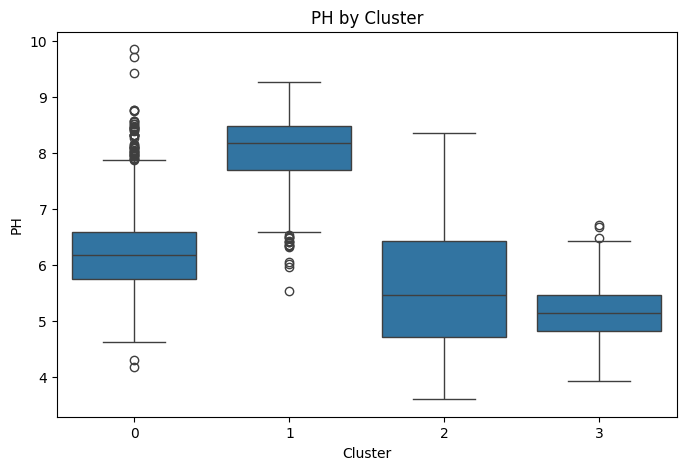

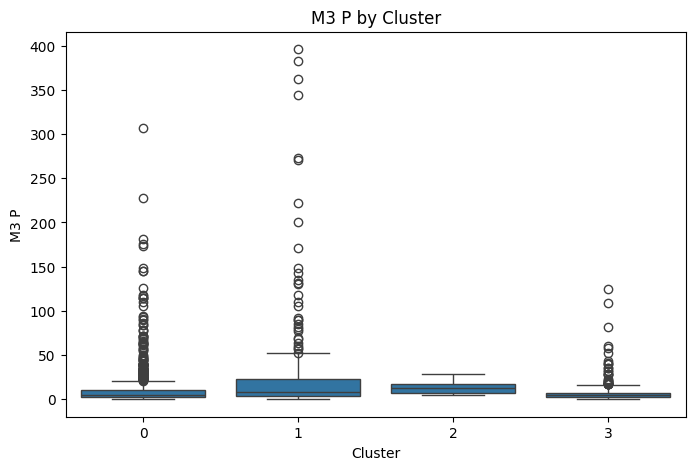

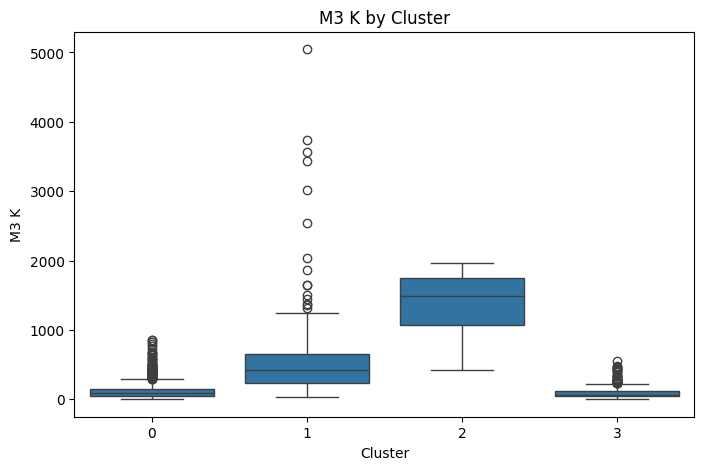

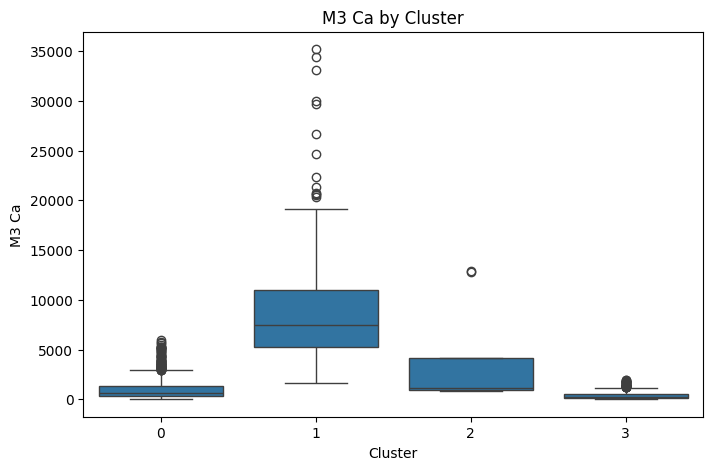

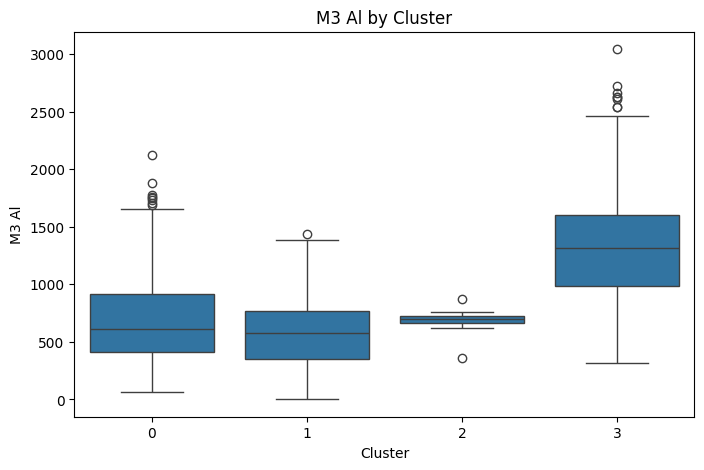

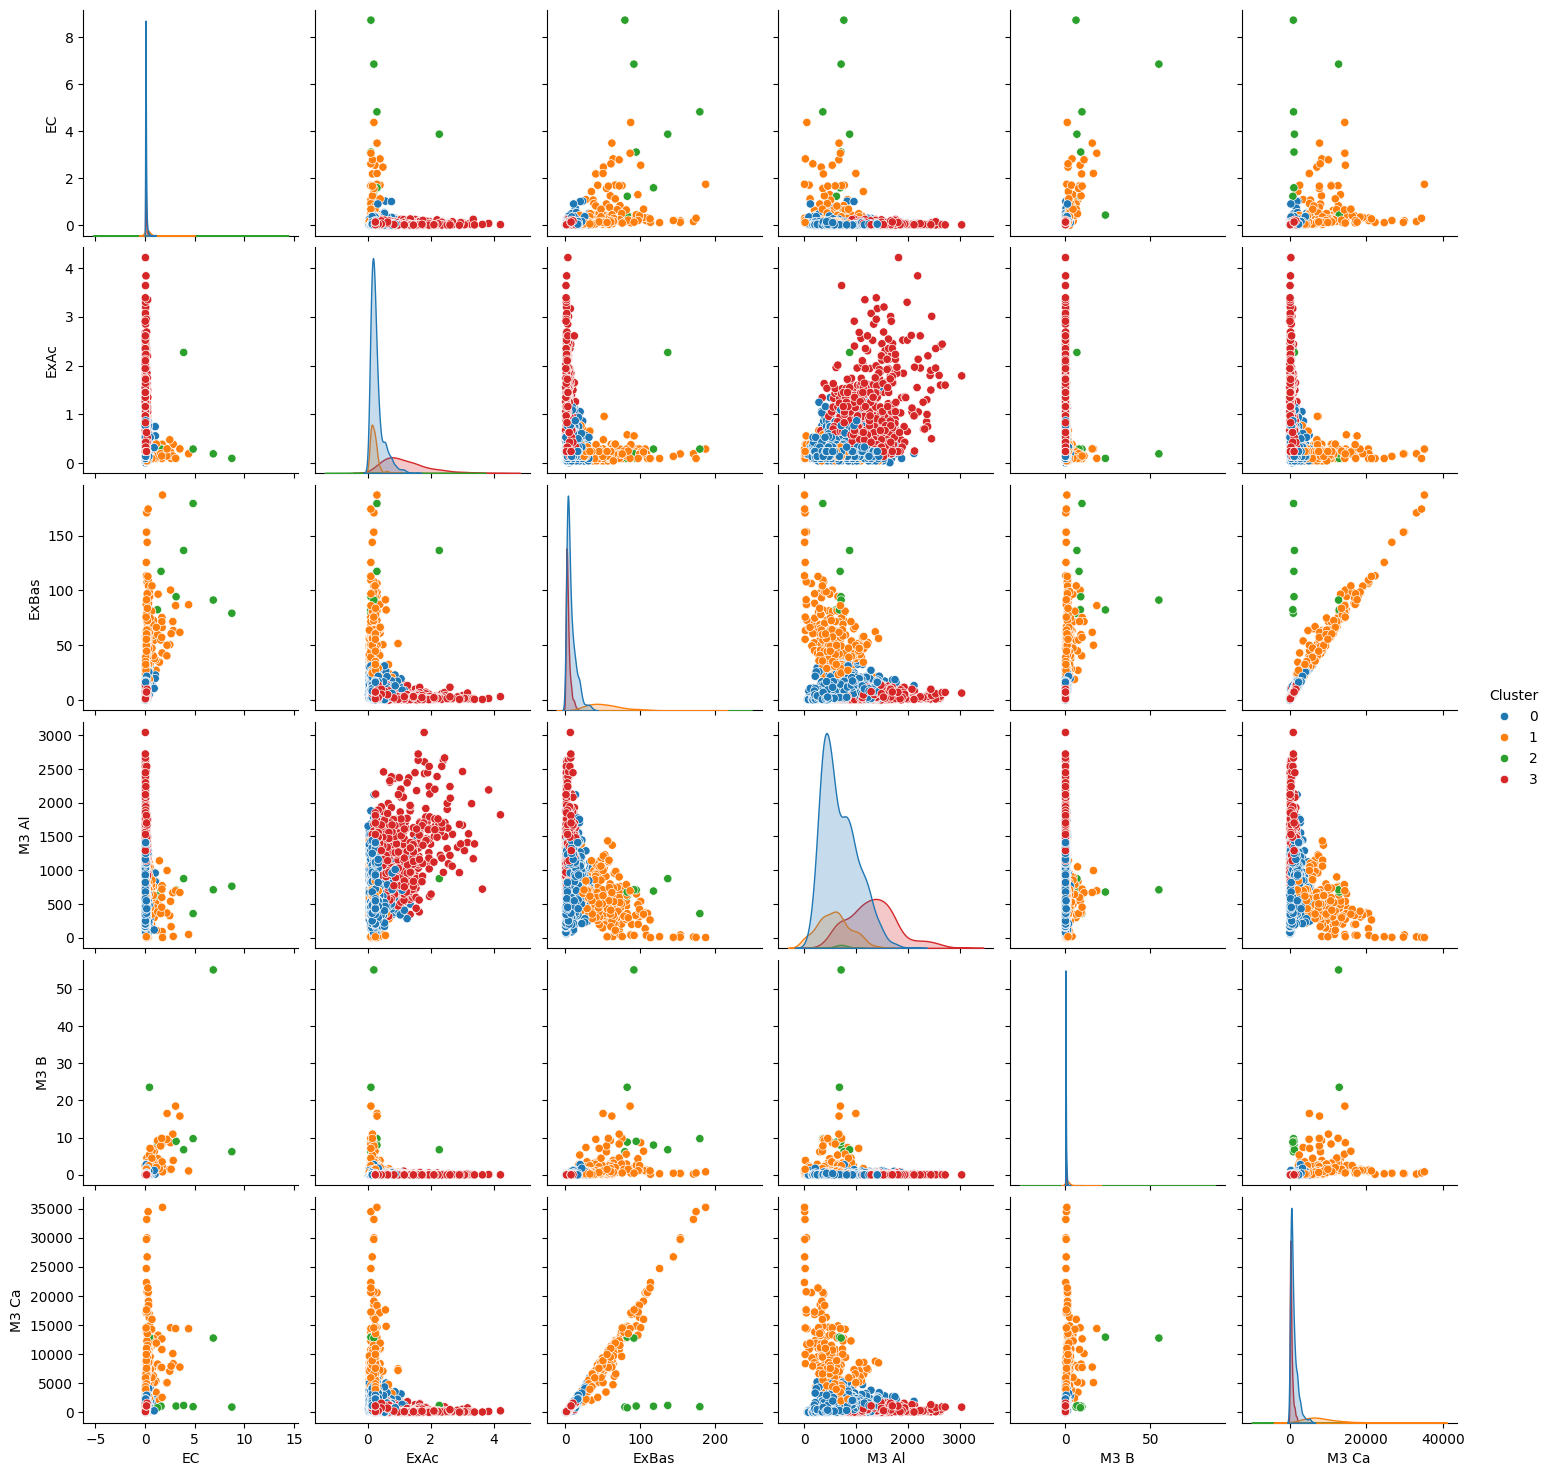


Clustering complete! Check centroids and plots to interpret groups.


In [15]:

# K-Means Clustering: AfSIS Wet Chemistry Soil Data
# Application - Clustering Soil Profiles
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
# Selecting clustering features
# All numerical soil chemistry columns (Mehlich-3 extractables + pH, EC, acidity/bases)
feature_cols = [
    'EC', 'ExAc', 'ExBas',
    'M3 Al', 'M3 B', 'M3 Ca', 'M3 Cu', 'M3 Fe', 'M3 K',
    'M3 Mg', 'M3 Mn', 'M3 Na', 'M3 P', 'M3 S', 'M3 Zn',
    'PH'
]

# Filtering to columns that actually exist
available_features = [col for col in feature_cols if col in df.columns]
print(f"\nUsing {len(available_features)} features: {available_features}")

X = df[available_features].copy()

# Handling missing values: fill with column mean (simple & common for soil data)
X = X.fillna(X.mean())
print(f"Rows for clustering: {X.shape[0]}")

# Scale the features (essential for K-Means!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled successfully.")

# Determine optimal number of clusters
inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans_temp.labels_))

# Plotting Elbow + Silhouette
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(k_range, inertias, 'bo-')
axs[0].set_title('Elbow Method (Inertia)')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Inertia')

axs[1].plot(k_range, sil_scores, 'go-')
axs[1].set_title('Silhouette Score')
axs[1].set_xlabel('k')
axs[1].set_ylabel('Score')
plt.tight_layout()
plt.show()

# Choosing k (look at plots: elbow bend + the highest silhouette)
# Soil data often clusters well into 3–6 groups (e.g. fertility levels)
best_k = 4  # this can be updated after seeing the plots (common sweet spot)
print(f"\nFitting K-Means with k = {best_k}")

# Final model
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Adding cluster labels back to original df
df['Cluster'] = kmeans.labels_

# Results
print("\nCluster sizes:")
print(df['Cluster'].value_counts().sort_index())

# Clustering centroids (back to original scale for easy interpretation)
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=available_features,
    index=[f"Cluster {i}" for i in range(best_k)]
)
print("\nCluster Centroids (original units):")
print(centroids.round(2))  # Rounded for readability

# Visualizations
# 1. Box plots of key variables by cluster
key_vars = ['PH', 'M3 P', 'M3 K', 'M3 Ca', 'M3 Al']  # Customize
for var in key_vars:
    if var in df.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='Cluster', y=var, data=df)
        plt.title(f'{var} by Cluster')
        plt.show()

# 2. Optional: Pair plot (if not too many features; subsample if slow)
sns.pairplot(df[available_features[:6] + ['Cluster']], hue='Cluster', palette='tab10')
plt.show()

# ── Saving results
df.to_csv('afsis_clustered.csv', index=False)
print("\nClustering complete! Check centroids and plots to interpret groups.")

In [16]:

# Adding Geographical Context: Join with Georeferences

import pandas as pd

# Loading georeferences dataset
GEOREF_PATH = '2009-2013/Georeferences/georeferences.csv'
georef = pd.read_csv(GEOREF_PATH)

print("Georeferences shape:", georef.shape)
print("Georeferences columns:", georef.columns.tolist())
print("\nFirst few rows of georef:")
print(georef.head())

# Joining on SSN (left join to keep all chemistry samples, even if no geo match)
df_geo = pd.merge(
    left=df,                # clustered chemistry df
    right=georef,
    on='SSN',               # The linking key
    how='left'              # Keeps all rows from chemistry df
)

print(f"\nAfter join: {df_geo.shape[0]} rows (some may have missing lat/lon if no match)")
print("Missing lat/lon count:", df_geo[['Latitude', 'Longitude']].isna().sum())  # Check for NAs

# Drop rows without location if you want only mappable samples
df_mappable = df_geo.dropna(subset=['Latitude', 'Longitude'])
print(f"Mappable samples: {df_mappable.shape[0]}")

Georeferences shape: (1843, 14)
Georeferences columns: ['SSN', 'Public', 'Latitude', 'Longitude', 'Cluster', 'Plot', 'Depth', 'Soil material', 'Scientist', 'Site', 'Country', 'Region', 'Cultivated', 'Gid']

First few rows of georef:
         SSN  Public   Latitude  Longitude  Cluster  Plot Depth  \
0  icr025136    True  -6.851620  34.243313       16     7   sub   
1  icr068579    True  11.280658   8.166768        9     1   top   
2  icr048978    True -29.972100  22.710200        1     1   sub   
3  icr056481    True -16.066365  28.326498       15     1   sub   
4  icr034190    True   8.158693   9.930640       15     1   top   

                     Soil material        Scientist      Site       Country  \
0                              NaN        Tor Vagen    Itende      Tanzania   
1   Pamp.9.1.Topsoil.Std fine soil    Jerome Tondoh  Pampaida       Nigeria   
2   Prie.1.1.Subsoil.Std fine soil  George Van Zijl   Prieska  South Africa   
3  Mong.15.1.Subsoil.Std fine soil        L.T.De

In [17]:

# Mapping the Clusters

import folium
from folium.plugins import MarkerCluster
import pandas as pd

# Step 1: Making sure we have clusters in the mappable dataframe
# If 'Cluster' is missing, re-attach it from the original clustered df
if 'Cluster' not in df_mappable.columns:
    print("Warning: 'Cluster' column missing from df_mappable → attempting to re-attach...")

    if 'Cluster' in df.columns:
        # Re-merge just the cluster labels using SSN
        df_mappable = df_mappable.merge(
            df[['SSN', 'Cluster']],
            on='SSN',
            how='left'
        )
        print("Successfully re-attached 'Cluster' column.")
    else:
        raise ValueError(
            "'Cluster' not found in original 'df' either. "
            "Please re-run your clustering cell first:\n"
            "df['Cluster'] = kmeans.labels_"
        )

# Quick verification
print("Columns now in df_mappable:", df_mappable.columns.tolist())
print("Cluster value counts (should show 0–3):")
print(df_mappable['Cluster'].value_counts(dropna=False).sort_index())

# Dropping any remaining rows without location or cluster
df_map_ready = df_mappable.dropna(subset=['Latitude', 'Longitude', 'Cluster'])
print(f"Ready to map: {df_map_ready.shape[0]} points")

# Step 2: Creating the interactive map
center_lat, center_lon = 0.35, 32.60
m = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles='CartoDB positron')

# Coloring mapping for clusters
cluster_colors = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red'}

# Using MarkerCluster to handle many points nicely
marker_cluster = MarkerCluster().add_to(m)

# Adding markers with safe access to values
for idx, row in df_map_ready.iterrows():
    cluster_id = int(row['Cluster'])  # ensure it's an integer

    popup_text = (
        f"<b>Cluster {cluster_id}</b><br>"
        f"SSN: {row.get('SSN', 'Unknown')}<br>"
        f"pH: {row.get('PH', 'N/A'):.2f}<br>"
        f"M3 P: {row.get('M3 P', 'N/A'):.1f} ppm<br>"
        f"EC: {row.get('EC', 'N/A'):.3f}"
    )

    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_text, max_width=250),
        icon=folium.Icon(
            color=cluster_colors.get(cluster_id, 'gray'),
            icon='info-sign',
            prefix='fa'
        )
    ).add_to(marker_cluster)

#Step 3: Add a simple legend (HTML overlay)
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 220px; height: 140px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px; opacity:0.9;">
     <b>Soil Cluster Legend</b><br>
     <i style="background:blue; width:12px; height:12px; display:inline-block;"></i> 0: Moderate / Balanced<br>
     <i style="background:green"></i> 1: High-base / Fertile<br>
     <i style="background:orange"></i> 2: Saline / High-Na Risk<br>
     <i style="background:red"></i> 3: Acidic / Low Fertility / High Al
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save and display
m.save('uganda_soil_clusters_map.html')
m


Successfully re-attached 'Cluster' column.
Columns now in df_mappable: ['SSN', 'Public_x', 'EC', 'ExAc', 'ExBas', 'M3 Al', 'M3 B', 'M3 Ca', 'M3 Cu', 'M3 Fe', 'M3 K', 'M3 Mg', 'M3 Mn', 'M3 Na', 'M3 P', 'M3 S', 'M3 Zn', 'PH', 'PSI', 'Cluster_x', 'Public_y', 'Latitude', 'Longitude', 'Cluster_y', 'Plot', 'Depth', 'Soil material', 'Scientist', 'Site', 'Country', 'Region', 'Cultivated', 'Gid', 'Cluster']
Cluster value counts (should show 0–3):
Cluster
0    1179
1     224
2       8
3     428
Name: count, dtype: int64
Ready to map: 1839 points
